In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (285).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (390).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (357).png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUS

In [18]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from torchvision.models import convnext_base
from einops import rearrange, repeat


In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
config = {
    "image_size": (128, 128),
    "batch_size": 16,
    "n_classes": 3,
    "epochs": 15,
    "learning_rate": 0.0001751240503867449,
    "data_dir": "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT",
    "base_model_save_path": "base_cnn_model.pth",
    "vit_model_save_path": "vit_model.pth",
    "convnext_vit_save_path": "final.pth",
    "vit_patch_size": 16,
    "vit_dim": 768,
    "vit_depth": 6,
    "vit_heads": 8,
    "vit_mlp_ratio": 4,
    "vit_dropout": 0.1,
    "vit_emb_dropout": 0.1,
    "class_names": ["Benign", "Malignant", "Normal"]
}

In [22]:
# Modified Dataset Class
class MedicalImageDataset(Dataset):
    def __init__(self, dataset_path, data_transforms=None):
        self.dataset_path = dataset_path
        self.data_transforms = data_transforms
        self.samples = []
        
        # Load samples for each category
        for category in ["benign", "malignant", "healthy"]:
            category_dir = os.path.join(dataset_path, category)
            for file in os.listdir(category_dir):
                if "mask" not in file.lower():
                    image_filepath = os.path.join(category_dir, file)
                    mask_filepath = os.path.join(category_dir, file.split(".")[0] + "_mask.png")
                    if os.path.exists(mask_filepath):
                        self.samples.append((image_filepath, mask_filepath, category))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_filepath, mask_filepath, category = self.samples[index]
        image = Image.open(image_filepath).convert("RGB")
        target_label = {"benign": 0, "malignant": 1, "healthy": 2}[category]
        
        # Apply transformation if provided
        if self.data_transforms:
            image = self.data_transforms(image)
        return image, target_label

# Data Preparation Function
def setup_data_loaders(params):
    # Data augmentations for the training set
    augmentation_train = transforms.Compose([
        transforms.Resize(params["input_size"]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Minimal processing for validation set
    augmentation_val = transforms.Compose([
        transforms.Resize(params["input_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Prepare dataset
    full_dataset = MedicalImageDataset(params["data_directory"], data_transforms=augmentation_train)
    split_train_size = int(0.75 * len(full_dataset))
    split_val_size = len(full_dataset) - split_train_size
    dataset_train, dataset_val = random_split(full_dataset, [split_train_size, split_val_size])

    # Loaders
    sampling_strategy = get_sampler(dataset_train)
    train_data_loader = DataLoader(dataset_train, batch_size=params["batch_size"], sampler=sampling_strategy)
    val_data_loader = DataLoader(dataset_val, batch_size=params["batch_size"], shuffle=False)

    return train_data_loader, val_data_loader, dataset_train, dataset_val


In [24]:
# Model Definition
class BaseCNN(nn.Module):
    def __init__(self, n_classes):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from typing import Tuple, Optional

class PatchEmbedding(nn.Module):
    """Split image into patches and embed them."""
    def __init__(self, image_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 768):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        # Use Conv2d instead of Linear for more efficient patch embedding
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        assert H == W == self.image_size, f"Input image size ({H}*{W}) doesn't match model ({self.image_size}*{self.image_size})"
        
        # (B, C, H, W) -> (B, embed_dim, H//patch_size, W//patch_size) -> (B, embed_dim, num_patches)
        x = self.proj(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        return x

class MultiHeadAttention(nn.Module):
    """Multi-head Self Attention mechanism."""
    def __init__(self, dim: int, num_heads: int = 8, dropout: float = 0.1):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)
        return x

class MLPBlock(nn.Module):
    """Transformer MLP block."""
    def __init__(self, dim: int, mlp_ratio: int = 4, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mlp_ratio, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: int = 4, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLPBlock(dim, mlp_ratio, dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_output = self.attn(self.norm1(x))
        x = x + attn_output  # Out-of-place addition for residual connection
        mlp_output = self.mlp(self.norm2(x))
        x = x + mlp_output  # Out-of-place addition for residual connection
        return x


class ViT(nn.Module):
    def __init__(
        self,
        image_size: int,
        patch_size: int,
        num_classes: int,
        dim: int = 768,
        depth: int = 12,
        heads: int = 12,
        mlp_ratio: int = 4,
        dropout: float = 0.1,
        emb_dropout: float = 0.1,
        channels: int = 3
    ):
        super().__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        
        self.patch_embed = PatchEmbedding(image_size, patch_size, channels, dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :(n + 1)]  # Out-of-place addition
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.norm(x)
        x = x[:, 0]  # Use CLS token
        return self.head(x)

    def load_from_mae(self, mae_state_dict: dict) -> None:
        """Load pre-trained weights from a Masked Autoencoder."""
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in mae_state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torchvision.models import ConvNeXt_Base_Weights
from einops import rearrange, repeat
from typing import Optional, Tuple, List


class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1)

class MeabsAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8, dropout: float = 0.1):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        
        # Initialize weights with smaller values
        self.qkv = nn.Linear(dim, dim * 3)
        nn.init.xavier_uniform_(self.qkv.weight, gain=0.01)
        
        # Add input projection for better feature transformation
        self.input_proj = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.local_enhance = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Dropout(dropout)  # Add dropout here
        )
        
        self.attn_dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_dropout = nn.Dropout(dropout)
        
        # Add gradient scaling factor
        self.attention_scale = nn.Parameter(torch.ones(1) * 0.1)

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = self.input_proj(x)  # Add input projection
        B, N, C = x.shape
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Enhanced local features with residual connection
        local_features = self.local_enhance(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        q = q + local_features

        # Compute attention with scaled dot product
        attn = (q @ k.transpose(-2, -1)) * self.scale * self.attention_scale
        
        if attention_mask is not None:
            attn = attn.masked_fill(attention_mask == 0, float('-inf'))
        
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return self.proj_dropout(x)


class MultiScaleFeatureFusion(nn.Module):
    """Fuses features from different scales of the ConvNeXt backbone."""
    def __init__(self, in_channels: List[int], out_channels: int):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_channels, 1),
                nn.BatchNorm2d(out_channels),
                nn.GELU()
            ) for in_ch in in_channels
        ])
        
        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels * len(in_channels), out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, features: List[torch.Tensor]) -> torch.Tensor:
        target_size = features[0].shape[-2:]
        processed_features = []
        
        for feat, conv in zip(features, self.convs):
            feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
            processed_features.append(conv(feat))
        
        x = torch.cat(processed_features, dim=1)
        return self.fusion(x)

class MedicalConvNeXtViT(nn.Module):
    def __init__(
        self,
        num_classes: int,
        image_size: int = 224,
        patch_size: int = 16,
        vit_dim: int = 768,
        vit_depth: int = 6,
        vit_heads: int = 8,
        vit_mlp_ratio: int = 4,
        dropout: float = 0.3,
        emb_dropout: float = 0.2,
        aux_loss: bool = True
    ):
        super().__init__()
        self.aux_loss = aux_loss
        
        # ConvNeXt backbone
        self.backbone = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Backbone normalization
        self.backbone_norm = nn.BatchNorm2d(1024)
        
        # Feature fusion
        self.feature_fusion = MultiScaleFeatureFusion([128, 256, 512, 1024], vit_dim)
        
        # Calculate the size after feature fusion
        self.fused_size = image_size // 32  # ConvNeXt downsamples by factor of 32
        
        # Patch embedding now properly handles the dimensions
        self.patch_embed = nn.Sequential(
            nn.Conv2d(vit_dim, vit_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2),  # Flatten spatial dimensions
            Permute()
        )
        
        # Calculate number of patches
        self.num_patches = (self.fused_size // patch_size) ** 2
        
        # Embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, vit_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, vit_dim))
        
        # Initialize embeddings
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)
        
        self.pos_drop = nn.Dropout(emb_dropout)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(vit_dim, vit_heads, vit_mlp_ratio, dropout)
            for _ in range(vit_depth)
        ])
        
        # Classification head
        self.norm = nn.LayerNorm(vit_dim)
        self.head = nn.Sequential(
            nn.Linear(vit_dim, vit_dim),
            nn.LayerNorm(vit_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(vit_dim, num_classes)
        )
        
        if aux_loss:
            self.aux_head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(1024, num_classes)
            )

    def extract_features(self, x: torch.Tensor) -> List[torch.Tensor]:
        features = []
        for i, layer in enumerate(self.backbone.features):
            x = layer(x)
            if i in [1, 3, 5, 7]:
                features.append(x)
        return features

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get backbone features
        if self.training:
            conv_features = []
            for i, layer in enumerate(self.backbone.features):
                x = layer(x)
                if i in [1, 3, 5, 7]:
                    conv_features.append(x)
        else:
            conv_features = self.extract_features(x)
        
        # Normalize last features
        conv_features[-1] = self.backbone_norm(conv_features[-1])
        
        # Fuse features
        x = self.feature_fusion(conv_features)  # Shape: [B, vit_dim, H, W]
        
        # Patch embedding
        x = self.patch_embed(x)  # Shape: [B, num_patches, vit_dim]
        
        # Add cls token
        cls_token = repeat(self.cls_token, '1 1 d -> b 1 d', b=x.shape[0])
        x = torch.cat((cls_token, x), dim=1)
        
        # Add position embedding
        if x.size(1) != self.pos_embedding.size(1):
            # Interpolate position embeddings if needed
            pos_embedding = F.interpolate(
                self.pos_embedding.transpose(1, 2),
                size=x.size(1),
                mode='linear'
            ).transpose(1, 2)
        else:
            pos_embedding = self.pos_embedding
            
        x = x + pos_embedding
        x = self.pos_drop(x)
        
        # Transform features
        for block in self.transformer_blocks:
            x = block(x)
        
        # Classification
        x = self.norm(x)
        cls_token_final = x[:, 0]
        main_out = self.head(cls_token_final)
        
        if self.aux_loss and self.training:
            aux_out = self.aux_head(conv_features[-1])
            return main_out, aux_out
            
        return main_out

class TransformerBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: int = 4, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


In [27]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        """
        Focal Loss implementation.
        Args:
            gamma (float): Focusing parameter for modulating factor (1-p).
            alpha (Tensor, optional): Class weights. If provided, should have the same length as the number of classes.
            reduction (str): Specifies the reduction to apply to the output. Options are 'none', 'mean', or 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Forward pass for Focal Loss.
        Args:
            inputs (Tensor): Predictions from the model (logits).
            targets (Tensor): Ground truth labels.
        Returns:
            Tensor: Computed Focal Loss.
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # Compute Cross-Entropy loss per sample
        pt = torch.exp(-ce_loss)  # Probabilities of the true class

        # Compute Focal Loss
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        # Apply class weights if provided
        if self.alpha is not None:
            alpha = self.alpha[targets].to(inputs.device)  # Select class-specific weights for each sample
            focal_loss = alpha * focal_loss

        # Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [28]:
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from torch.amp import GradScaler
from torch.amp import autocast
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def get_sampler(dataset):
    """Create a weighted sampler to handle class imbalance"""
    labels = [label for _, label in dataset]
    class_counts = np.bincount(labels)
    weights = 1.0 / class_counts
    sample_weights = weights[labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    return sampler


def train_and_evaluate(model, train_loader, val_loader, config, device, class_weights=None, save_dir="./results"):
    """Enhanced training function with stability improvements, best F1 tracking, and confusion matrix saving."""
    
    # Loss function with class weights
    criterion = FocalLoss(gamma=3, alpha=class_weights)
    
    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=1.5,
        betas=(0.9, 0.999)
    )
    
    # Cosine learning rate scheduler with warmup
    num_training_steps = config['epochs'] * len(train_loader)
    num_warmup_steps = num_training_steps // 10
    
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
    
    # Gradient scaler for mixed precision training
    scaler = GradScaler()
    
    # Track best F1 score
    best_f1 = 0
    best_model_weights = None
    best_epoch_preds, best_epoch_labels = None, None

    # Initialize metrics storage
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_f1": [],
        "val_f1": [],
        "train_precision": [],
        "val_precision": [],
        "train_recall": [],
        "val_recall": []
    }

    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        all_preds, all_labels = [], []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with autocast(device_type="cuda"):
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = criterion(outputs, targets)
            
            # Gradient scaling and backward pass
            scaler.scale(loss).backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Optimizer step with gradient scaling
            scaler.step(optimizer)
            scaler.update()
            
            # Learning rate scheduling
            scheduler.step()
            
            # Compute metrics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
        
        # Calculate detailed training metrics
        train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                with autocast(device_type="cuda"):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
                
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(targets.cpu().numpy())
        
        # Calculate detailed validation metrics
        val_precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

        # Track the best F1 score and save the model weights
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_weights = model.state_dict()
            best_epoch_preds = val_preds
            best_epoch_labels = val_labels

        # Compute and print epoch metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        # Append metrics for this epoch
        metrics["train_loss"].append(train_loss / len(train_loader))
        metrics["val_loss"].append(val_loss / len(val_loader))
        metrics["train_acc"].append(train_acc)
        metrics["val_acc"].append(val_acc)
        metrics["train_f1"].append(train_f1)
        metrics["val_f1"].append(val_f1)
        metrics["train_precision"].append(train_precision)
        metrics["val_precision"].append(val_precision)
        metrics["train_recall"].append(train_recall)
        metrics["val_recall"].append(val_recall)
        
        print(f'Epoch: {epoch+1}/{config["epochs"]}')
        print(f'Train Loss: {metrics["train_loss"][-1]:.4f}, '
              f'Train Acc: {metrics["train_acc"][-1]:.4f}, '
              f'Train Precision: {metrics["train_precision"][-1]:.4f}, '
              f'Train Recall: {metrics["train_recall"][-1]:.4f}, '
              f'Train F1: {metrics["train_f1"][-1]:.4f}')
        print(f'Val Loss: {metrics["val_loss"][-1]:.4f}, '
              f'Val Acc: {metrics["val_acc"][-1]:.4f}, '
              f'Val Precision: {metrics["val_precision"][-1]:.4f}, '
              f'Val Recall: {metrics["val_recall"][-1]:.4f}, '
              f'Val F1: {metrics["val_f1"][-1]:.4f}')
        print("-" * 50)

    # Save confusion matrix and print misclassified images for the best epoch
    print(f"Best F1 Score: {best_f1:.4f}")
    save_confusion_matrix(best_epoch_labels, best_epoch_preds, model_name=config['model_name'], save_dir=save_dir)
    print_misclassified_images(best_epoch_labels, best_epoch_preds, val_loader.dataset, num_examples=5)

    # Return metrics and best weights
    return metrics, best_model_weights


def save_confusion_matrix(labels, preds, model_name, save_dir):
    """Save confusion matrix as an image."""
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{model_name}_best_confusion_matrix.png")
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    disp.figure_.savefig(save_path)
    print(f"Confusion matrix saved to {save_path}")


def print_misclassified_images(labels, preds, dataset, num_examples=5):
    """Print and visualize some misclassified images."""
    misclassified_indices = [i for i, (y_true, y_pred) in enumerate(zip(labels, preds)) if y_true != y_pred]
    print(f"Number of misclassified examples: {len(misclassified_indices)}")
    
    if len(misclassified_indices) == 0:
        print("No misclassified examples found.")
        return

    print(f"Displaying up to {num_examples} misclassified images:")
    for idx in misclassified_indices[:num_examples]:
        image, true_label = dataset[idx]
        predicted_label = preds[idx]

        # Display the image and labels
        plt.figure(figsize=(4, 4))
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC for display
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis("off")
        plt.show()


def print_metrics(labels, preds):
    """Print detailed classification metrics"""
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


In [29]:
def initialize_model(model_name, config, device):
    if model_name == "base_cnn":
        model = BaseCNN(config["n_classes"]).to(device)
        save_path = config["base_model_save_path"]
    elif model_name == "vit":
        model = ViT(
            image_size=config["image_size"][0],
            patch_size=config["vit_patch_size"],
            num_classes=config["n_classes"],
            dim=config["vit_dim"],
            depth=config["vit_depth"],
            heads=config["vit_heads"],
            mlp_ratio=config["vit_mlp_ratio"],
            dropout=config["vit_dropout"],
            emb_dropout=config["vit_emb_dropout"]
        ).to(device)
        save_path = config["vit_model_save_path"]
    elif model_name == "convnext_vit":
        model = MedicalConvNeXtViT(
            num_classes=config["n_classes"],
            image_size=config["image_size"][0],
            patch_size=config["vit_patch_size"],
            vit_dim=config["vit_dim"],
            vit_depth=config["vit_depth"],
            vit_heads=config["vit_heads"],
            vit_mlp_ratio=config["vit_mlp_ratio"],
            dropout=config["vit_dropout"],
            emb_dropout=config["vit_emb_dropout"]
        ).to(device)
        save_path = config["convnext_vit_save_path"]
    else:
        raise ValueError("Invalid model name")

    return model, save_path


In [30]:
def plot_metrics(metrics_dict, metric_names=["Loss", "Accuracy", "Precision", "Recall", "F1-Score"]):
    """
    Plots training and validation metrics for multiple models.
    
    Args:
        metrics_dict (dict): Dictionary containing metric lists for multiple models. 
                             Format: 
                             {
                                 "model_name": {
                                     "train_loss": [...],
                                     "val_loss": [...],
                                     "train_acc": [...],
                                     "val_acc": [...],
                                     "train_precision": [...],
                                     "val_precision": [...],
                                     "train_recall": [...],
                                     "val_recall": [...],
                                     "train_f1": [...],
                                     "val_f1": [...]
                                 }
                             }
        metric_names (list): List of metric names to plot.
    """
    num_epochs = len(next(iter(metrics_dict.values()))["train_loss"])
    epochs = range(1, num_epochs + 1)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for metric_name in metric_names:
        plt.figure(figsize=(12, 6))
        for idx, (model_name, metrics) in enumerate(metrics_dict.items()):
            train_metric = metrics.get(f"train_{metric_name.lower()}", [])
            val_metric = metrics.get(f"val_{metric_name.lower()}", [])
            
            if train_metric:
                plt.plot(epochs, train_metric, linestyle='--', color=colors[idx % len(colors)], 
                         label=f"{model_name} Train {metric_name}")
            if val_metric:
                plt.plot(epochs, val_metric, color=colors[idx % len(colors)], 
                         label=f"{model_name} Val {metric_name}")
        
        plt.title(f"{metric_name} Comparison Across Models")
        plt.xlabel("Epochs")
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid()
        plt.show()



==================== Training BASE_CNN ====================
Epoch: 1/15
Train Loss: 0.3339, Train Acc: 0.3526, Train Precision: 0.3504, Train Recall: 0.3526, Train F1: 0.3509
Val Loss: 0.3270, Val Acc: 0.2564, Val Precision: 0.3487, Val Recall: 0.2564, Val F1: 0.1957
--------------------------------------------------
Epoch: 2/15
Train Loss: 0.3170, Train Acc: 0.3750, Train Precision: 0.3775, Train Recall: 0.3750, Train F1: 0.3731
Val Loss: 0.3122, Val Acc: 0.3910, Val Precision: 0.4751, Val Recall: 0.3910, Val F1: 0.3135
--------------------------------------------------
Epoch: 3/15
Train Loss: 0.2994, Train Acc: 0.4679, Train Precision: 0.4692, Train Recall: 0.4679, Train F1: 0.4672
Val Loss: 0.2940, Val Acc: 0.4295, Val Precision: 0.6050, Val Recall: 0.4295, Val F1: 0.3939
--------------------------------------------------
Epoch: 4/15
Train Loss: 0.3007, Train Acc: 0.4904, Train Precision: 0.4868, Train Recall: 0.4904, Train F1: 0.4861
Val Loss: 0.2658, Val Acc: 0.5256, Val Precisio

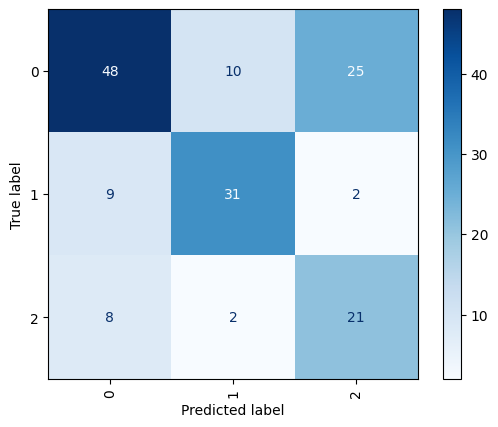

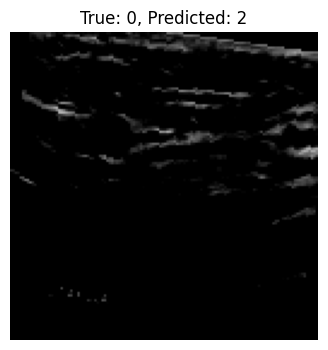

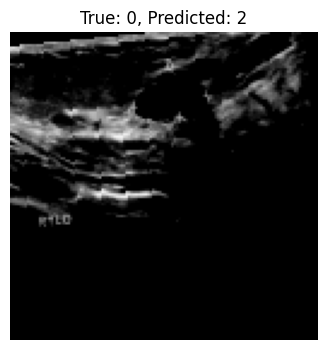

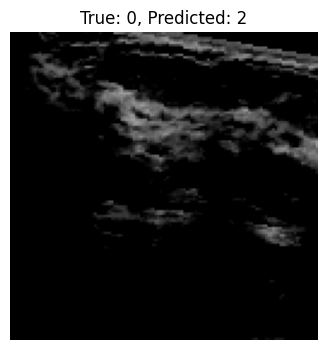

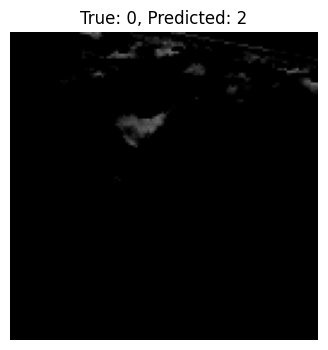

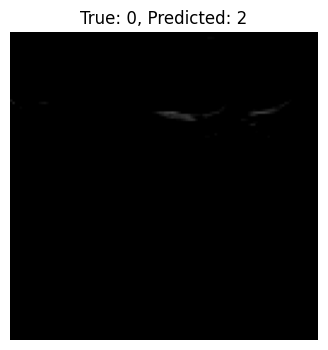

Best model for BASE_CNN saved at base_cnn_model.pth

==================== Training VIT ====================
Epoch: 1/15
Train Loss: 0.4110, Train Acc: 0.3237, Train Precision: 0.3242, Train Recall: 0.3237, Train F1: 0.3230
Val Loss: 0.3735, Val Acc: 0.3013, Val Precision: 0.1407, Val Recall: 0.3013, Val F1: 0.1907
--------------------------------------------------
Epoch: 2/15
Train Loss: 0.4856, Train Acc: 0.3429, Train Precision: 0.3508, Train Recall: 0.3429, Train F1: 0.3380
Val Loss: 0.6100, Val Acc: 0.3718, Val Precision: 0.1745, Val Recall: 0.3718, Val F1: 0.2364
--------------------------------------------------
Epoch: 3/15
Train Loss: 0.4033, Train Acc: 0.3814, Train Precision: 0.3814, Train Recall: 0.3814, Train F1: 0.3814
Val Loss: 0.3594, Val Acc: 0.3397, Val Precision: 0.1983, Val Recall: 0.3397, Val F1: 0.2309
--------------------------------------------------
Epoch: 4/15
Train Loss: 0.3630, Train Acc: 0.4279, Train Precision: 0.4237, Train Recall: 0.4279, Train F1: 0.4241


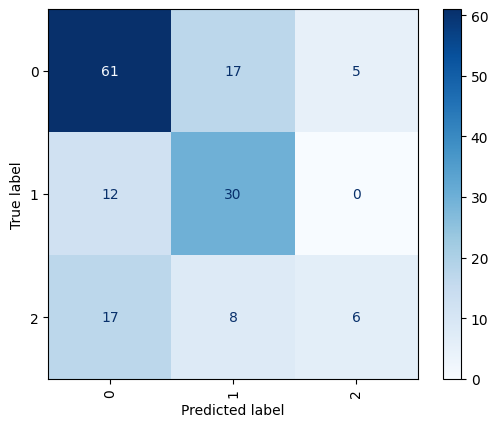

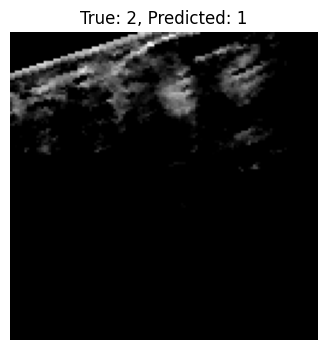

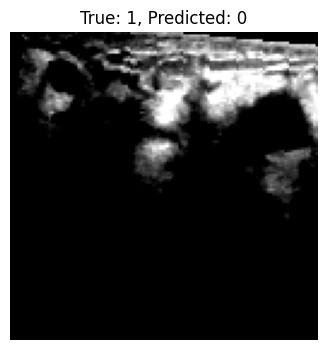

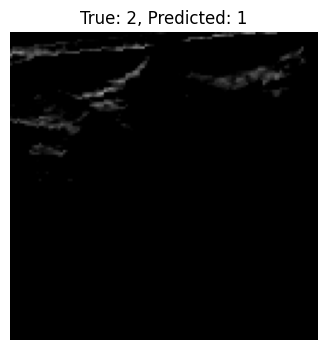

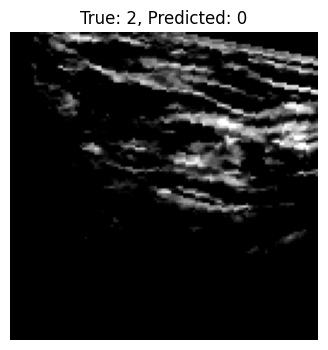

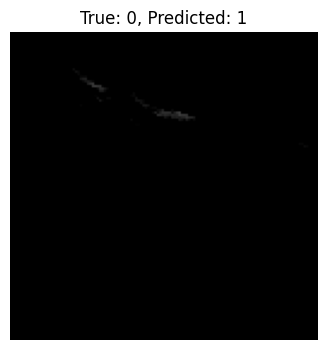

Best model for VIT saved at vit_model.pth

==================== Training CONVNEXT_VIT ====================


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:02<00:00, 173MB/s] 


In [ ]:
if __name__ == "__main__":
    # Device Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare DataLoaders
    train_loader, val_loader, train_ds, val_ds = prepare_dataloaders(config)

    # Initialize metrics dictionary
    metrics_dict = {}

    # Compute class weights for weighted loss
    class_labels = [label for _, label in train_ds]
    class_weights = compute_class_weight("balanced", classes=range(config["n_classes"]), y=class_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    for model_name in ["base_cnn", "vit", "convnext_vit"]:
        print(f"\n{'='*20} Training {model_name.upper()} {'='*20}")
    
        # Initialize model
        model, save_path = initialize_model(model_name, config, device)
    
        # Add model name to config
        config["model_name"] = model_name
    
        # Training configuration
        weights = class_weights if model_name == "convnext_vit" else None
    
        # Train and evaluate
        metrics, best_weights = train_and_evaluate(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            config=config,
            device=device,
            class_weights=weights,
            save_dir=f"./results/{model_name}"
        )
    
        # Save the best model weights
        if best_weights:
            torch.save(best_weights, save_path)
            print(f"Best model for {model_name.upper()} saved at {save_path}")
    
        # Store metrics for comparison
        metrics_dict[model_name.upper()] = metrics
